In [5]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

cudnn.benchmark = True

### Set the root directory 

In [7]:
!ls "/playground/data/augmentation/fruit"

test  train_val


In [8]:
dataset_directory = "/playground/data/augmentation/fruit"

In [9]:
N_CLASSES = 2

groups = os.listdir(dataset_directory)  # train, val, test

labels_in_gropus = [sorted(os.listdir(os.path.join(dataset_directory, group)))
                    for group in groups]

# в каждой группе должно быть одинаковое количество классов
assert all([len(labels)==N_CLASSES for labels in labels_in_gropus])

# названия соответствующих классов во всех группах совпадают
assert all([len(set(same_labels))==1 for same_labels in zip(*labels_in_gropus)])     

labels = labels_in_gropus[0]

cl2id = {l:i for i,l in enumerate(labels)}
id2cl = {i:l for l,i in cl2id.items()}

print(cl2id)
print(id2cl)

{'apple': 0, 'banana': 1}
{0: 'apple', 1: 'banana'}


### Split files from the dataset into the train and validation sets

In [10]:
images_filepaths = dict()
images_filepaths['train'] = []
images_filepaths['val'] = []
images_filepaths['test'] = []

for gr in groups:
    for cl in labels:
        _images_filepaths = glob(os.path.join(dataset_directory,gr,cl,"*.jpg"), recursive=True)
        correct_images_filepaths = [i for i in _images_filepaths if cv2.imread(i) is not None]
        random.seed(42)
        random.shuffle(correct_images_filepaths)
        if gr == 'train_val':
            split = int(len(correct_images_filepaths) * 0.75)
            images_filepaths['train'].extend(correct_images_filepaths[:split])
            images_filepaths['val'].extend(correct_images_filepaths[split:])
        elif gr == 'test':
            images_filepaths['test'].extend(correct_images_filepaths)

for group, paths in images_filepaths.items():
    print(f"{len(paths)} images in {group}")    

74 images in train
26 images in val
24 images in test


### Define a function to visualize images and their labels

In [11]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = image_filepath.split('/')[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

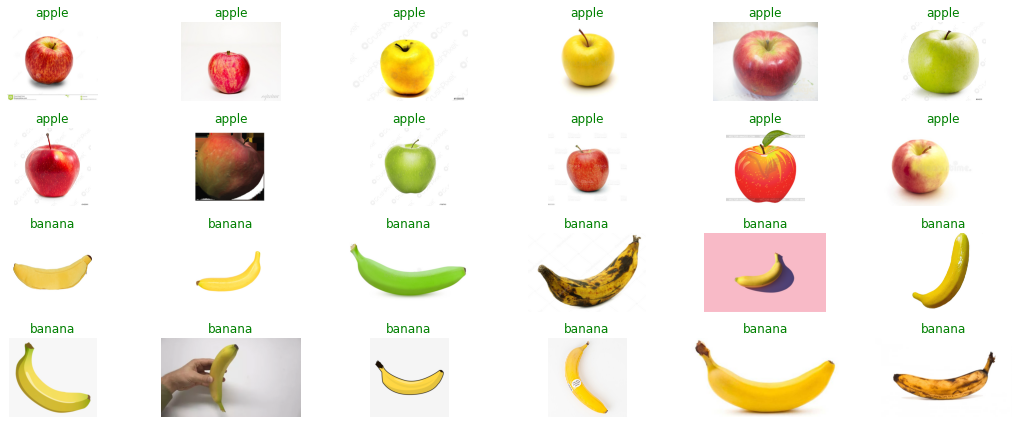

In [12]:
display_image_grid(images_filepaths['test'], cols=6)

### Define a PyTorch dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

Out task is binary classification - a model needs to predict whether an image contains a cat or a dog. Our labels will mark the probability that an image contains a cat. So the correct label for an image with a cat will be `1.0`, and the correct label for an image with a dog will be `0.0`.

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and return it along with the correct label.

In [30]:
class AppleVsBananaDataset(Dataset):
    def __init__(self, images_filepaths, mapping, transform=None):
        self.images_filepaths = images_filepaths
        self.mapping = mapping
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cl = image_filepath.split('/')[-2]
        label = self.mapping[cl]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

### Use Albumentations to define transformation functions for the train and validation datasets

We use Albumentations to define augmentation pipelines for training and validation datasets. In both pipelines, we first resize an input image, so its smallest size is 160px, then we take a 128px by 128px crop. For the training dataset, we also apply more augmentations to that crop. Next, we will normalize an image. We first divide all pixel values of an image by 255, so each pixel's value will lie in a range `[0.0, 1.0]`. Then we will subtract mean pixel values and divide values by the standard deviation. `mean` and `std` in augmentation pipelines are taken from the [`ImageNet` dataset](http://www.image-net.org/). Still, they transfer reasonably well to the `Cats vs. Dogs` dataset. After that, we will apply `ToTensorV2` that converts a NumPy array to a PyTorch tensor, which will serve as an input to a neural network.

Note that in the validation pipeline we will use `A.CenterCrop` instead of `A.RandomCrop` because we want out validation results to be deterministic (so that they will not depend upon a random location of a crop).

In [31]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CenterCrop(height=128, width=128),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = AppleVsBananaDataset(images_filepaths=images_filepaths['train'], 
                                     mapping=cl2id, 
                                     transform=train_transform)

In [15]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = AppleVsBananaDataset(images_filepaths=images_filepaths['val'],
                                   mapping=cl2id,
                                   transform=val_transform)

Also let's define a function that takes a dataset and visualizes different augmentations applied to the same image.

In [16]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

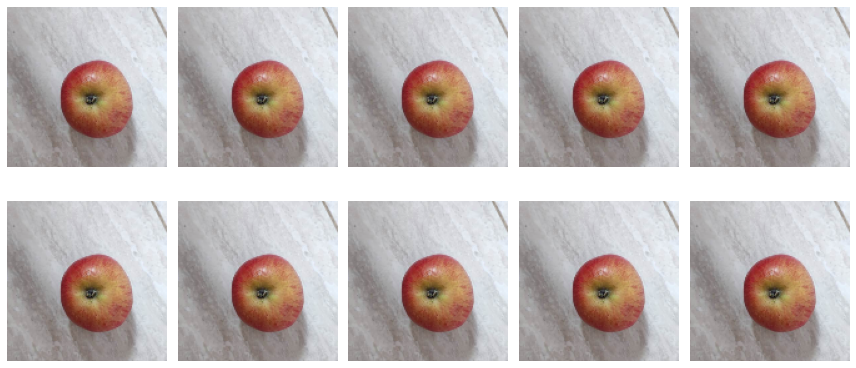

In [17]:
random.seed(42)
visualize_augmentations(train_dataset, 13)

### Define helpers for training

We define a few helpers for our training pipeline. `calculate_accuracy` takes model predictions and true labels and will return accuracy for those predictions. `MetricMonitor` helps to track metrics such as accuracy or loss during training and validation

In [18]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [19]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### Define training parameters 

Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc

In [20]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 8,
    "num_workers": 4,
    "epochs": 10,
}

### Create all required objects and functions for training and validation

In [21]:
model = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [22]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [23]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images) 
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Acc", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [24]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            metric_monitor.update("Loss_", loss.item())
            metric_monitor.update("Acc_", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

### Train a model

In [25]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 1.065 | Acc: 0.550: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]
Epoch: 1. Validation. Loss_: 0.685 | Acc_: 0.594: 100%|██████████| 4/4 [00:00<00:00, 11.75it/s]
Epoch: 2. Train.      Loss: 0.870 | Acc: 0.662: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s]
Epoch: 2. Validation. Loss_: 2.319 | Acc_: 0.438: 100%|██████████| 4/4 [00:00<00:00, 11.72it/s]
Epoch: 3. Train.      Loss: 1.034 | Acc: 0.750: 100%|██████████| 10/10 [00:00<00:00, 10.98it/s]
Epoch: 3. Validation. Loss_: 3.865 | Acc_: 0.406: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]
Epoch: 4. Train.      Loss: 0.697 | Acc: 0.675: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s]
Epoch: 4. Validation. Loss_: 2.513 | Acc_: 0.844: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]
Epoch: 5. Train.      Loss: 0.440 | Acc: 0.838: 100%|██████████| 10/10 [00:00<00:00, 11.01it/s]
Epoch: 5. Validation. Loss_: 0.634 | Acc_: 0.781: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s]
Epoch: 6. Train.      Loss: 0.362 | Acc:

### Predict labels for images and visualize those predictions

In [32]:
class AppleVsBananaInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = AppleVsBananaInferenceDataset(images_filepaths=images_filepaths['test'], transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [33]:
model = model.eval()
predicted_labels = []
predicted_scores = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = torch.sigmoid(output).cpu().numpy().flatten() 
        predicted_scores += list(predictions)
        predicted_labels += [id2cl[int(pred)] for pred in predictions >= 0.5]

y_true = [p.split('/')[-2] for p in images_filepaths['test']]

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true,predicted_labels))

              precision    recall  f1-score   support

       apple       1.00      0.08      0.15        12
      banana       0.52      1.00      0.69        12

    accuracy                           0.54        24
   macro avg       0.76      0.54      0.42        24
weighted avg       0.76      0.54      0.42        24



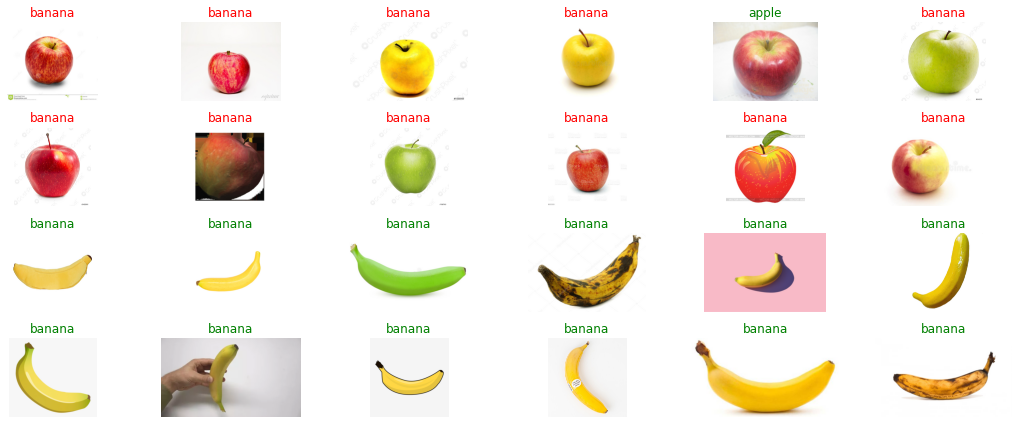

In [35]:
display_image_grid(images_filepaths['test'], predicted_labels, cols=6)